In [1]:
import pandas as pd
import datetime as dt
from  tqdm import tqdm
from surprise import Reader, Dataset
from surprise import BaselineOnly 
from surprise import accuracy
from surprise import KNNBaseline
from surprise import SVD,SVDpp
from surprise.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("train.csv",usecols=['movie','user','rating'],nrows=325000)
test=pd.read_csv("test.csv",usecols=['movie','user','rating'],nrows=22000)
print(df.shape[0])
print(test.shape[0])

325000
22000


<h1> Transforming data into Suprise lib format </h1> 

In [3]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user', 'movie', 'rating']], reader=reader)
train_data= data.build_full_trainset() 

In [4]:
testset = list(zip(test.user.values,test.movie.values,test.rating.values))
testset[:3]

[(2019776, 3151, 4), (684822, 1645, 4), (1091065, 5836, 3)]

In [5]:
start = dt.datetime.now()
bsl_options = {'method': 'als'}
print("Estimating biases using als...")
for i in range(25,51,5):
    bsl_options['n_epochs']=i
    algo = BaselineOnly(bsl_options=bsl_options,verbose=False)
    algo.fit(train_data)
    print('-'*75)
    print("Accuracy for n_epochs :",i)
    predictions = algo.test(train_data.build_testset())
    print("RMSE on Train data:",accuracy.rmse(predictions))

    predictions = algo.test(testset)
    print("RMSE on Test data:",accuracy.rmse(predictions))

print("Time taken:",dt.datetime.now()-start)

Estimating biases using als...
---------------------------------------------------------------------------
Accuracy for n_epochs : 25
RMSE: 0.9590
RMSE on Train data: 0.9590395499489365
RMSE: 1.1267
RMSE on Test data: 1.1266872759877535
---------------------------------------------------------------------------
Accuracy for n_epochs : 30
RMSE: 0.9590
RMSE on Train data: 0.9590390037768974
RMSE: 1.1267
RMSE on Test data: 1.126672601824176
---------------------------------------------------------------------------
Accuracy for n_epochs : 35
RMSE: 0.9590
RMSE on Train data: 0.9590388306948688
RMSE: 1.1267
RMSE on Test data: 1.1266679386074023
---------------------------------------------------------------------------
Accuracy for n_epochs : 40
RMSE: 0.9590
RMSE on Train data: 0.9590387757237234
RMSE: 1.1267
RMSE on Test data: 1.1266664561786224
---------------------------------------------------------------------------
Accuracy for n_epochs : 45
RMSE: 0.9590
RMSE on Train data: 0.95903875

In [6]:
start = dt.datetime.now()
bsl_options = {'method': 'sgd','learning_rate':0.001}
print("Estimating biases using sgd with learning rate 0.001...")
for i in range(20,51,5):
    bsl_options['n_epochs']=i
    algo = BaselineOnly(bsl_options=bsl_options,verbose=False)
    algo.fit(train_data)
    print('-'*75)
    print("Accuracy for n_epochs :",i)
    predictions = algo.test(train_data.build_testset())
    print("RMSE on Train data:",accuracy.rmse(predictions))

    predictions = algo.test(testset)
    print("RMSE on Test data:",accuracy.rmse(predictions))


print("Time taken:",dt.datetime.now()-start)

Estimating biases using sgd with learning rate 0.001...
---------------------------------------------------------------------------
Accuracy for n_epochs : 20
RMSE: 0.9671
RMSE on Train data: 0.9670651058268297
RMSE: 1.1275
RMSE on Test data: 1.1275127926010793
---------------------------------------------------------------------------
Accuracy for n_epochs : 25
RMSE: 0.9644
RMSE on Train data: 0.964396045699053
RMSE: 1.1274
RMSE on Test data: 1.127412703995411
---------------------------------------------------------------------------
Accuracy for n_epochs : 30
RMSE: 0.9625
RMSE on Train data: 0.9624848101047251
RMSE: 1.1273
RMSE on Test data: 1.1273340034020556
---------------------------------------------------------------------------
Accuracy for n_epochs : 35
RMSE: 0.9610
RMSE on Train data: 0.9610438045280065
RMSE: 1.1273
RMSE on Test data: 1.1272722353452815
---------------------------------------------------------------------------
Accuracy for n_epochs : 40
RMSE: 0.9599
RMSE o

# Storing baseline result for Xgb feature

In [7]:
#Baseline with als method
bsl_options = {'method': 'als','n_epochs':50}
algo = BaselineOnly(bsl_options=bsl_options,verbose=True)
algo.fit(train_data)

xgb_train,xgb_test=pd.DataFrame(),pd.DataFrame()
#preparing train data for xgboost algo
train_predictions = algo.test(train_data.build_testset())
xgb_train['bsl_als']=[train_predictions[i][3] for i in range(df.shape[0])]
xgb_train['rating']=df.rating

#preparing test data for xgboost algo
test_predictions = algo.test(testset)
xgb_test['bsl_als']=[test_predictions[i][3] for i in range(test.shape[0])]
xgb_test['rating']=test.rating

Estimating biases using als...


In [8]:
#Baseline with sgd method
bsl_options = {'method': 'sgd','n_epochs':50,'learning_rate':0.001}
algo = BaselineOnly(bsl_options=bsl_options,verbose=True)
algo.fit(train_data)

#preparing train data for xgboost algo
train_predictions = algo.test(train_data.build_testset())
xgb_train['bsl_sgd']=[train_predictions[i][3] for i in range(df.shape[0])]

#preparing test data for xgboost algo
test_predictions = algo.test(testset)
xgb_test['bsl_sgd']=[test_predictions[i][3] for i in range(test.shape[0])]

Estimating biases using sgd...


In [9]:
#train data
print(xgb_train.shape[0])
xgb_train.head()

325000


,bsl_als,rating,bsl_sgd
0,2.982229,3,2.934491
1,3.338582,5,3.325061
2,3.160165,2,3.162555
3,3.187672,5,3.172830
4,2.939256,4,2.943452


In [10]:
#train data
print(xgb_test.shape[0])
xgb_test.head()

22000


,bsl_als,rating,bsl_sgd
0,3.320431,4,3.320431
1,3.320431,4,3.320431
2,3.320431,3,3.320431
3,3.762526,4,3.765154
4,3.320431,2,3.320431


In [11]:
xgb_train.to_csv("sur_xgb_train.csv")
xgb_test.to_csv("sur_xgb_test.csv")

# K-NN baseline with hyperparameter tuning

In [15]:
start=dt.datetime.now()

sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'als'} 
algo =KNNBaseline(sim_options =sim_options ,bsl_options=bsl_options)
param_grid = {'k': [30,35,40,45,50],'min_k':[1,2,3,4,5]}
k_range,min_k_range=[30,35,40,45,50],[1,2,3,4,5]
RMSE={}
for k in tqdm(k_range):
    for min_k in tqdm(min_k_range):
        knn_bsl_u=KNNBaseline(k=k,min_k=min_k,sim_options=sim_options,bsl_options=bsl_options)
        knn_bsl_u.fit(train_data)
        
        print('-'*75)
        print("Accuracy for k={} and min_k={} :".format(k,min_k))
        predictions = knn_bsl_u.test(train_data.build_testset())
        print("RMSE on Train data:",accuracy.rmse(predictions))

        predictions = knn_bsl_u.test(testset)
        print("RMSE on Test data:",accuracy.rmse(predictions))
        RMSE[(k,min_k)]=accuracy.rmse(predictions)


print("Time Taken : ",dt.datetime.now()-start)

  0%|          | 0/5 [00:00<?, ?it/s]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=30 and min_k=1 :
RMSE: 0.4845
RMSE on Train data: 0.48452001627709074
RMSE: 1.1273
RMSE on Test data: 1.1272861578209328



 20%|██        | 1/5 [08:02<32:08, 482.18s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=30 and min_k=2 :
RMSE: 0.4875
RMSE on Train data: 0.4875014100499093
RMSE: 1.1273
RMSE on Test data: 1.1273306447495877



 40%|████      | 2/5 [16:31<24:47, 495.97s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=30 and min_k=3 :
RMSE: 0.4899
RMSE on Train data: 0.4898637134877161



 60%|██████    | 3/5 [24:07<16:05, 482.67s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273156037495708
RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=30 and min_k=4 :
RMSE: 0.4923
RMSE on Train data: 0.49232913395562905
RMSE: 1.1273
RMSE on Test data: 1.1273156037495708



 80%|████████  | 4/5 [32:43<08:10, 490.76s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=30 and min_k=5 :
RMSE: 0.4946
RMSE on Train data: 0.49457831953317066



100%|██████████| 5/5 [40:58<00:00, 491.78s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273156037495708
RMSE: 1.1273



  0%|          | 0/5 [00:00<?, ?it/s]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=35 and min_k=1 :
RMSE: 0.4990
RMSE on Train data: 0.4989815902439657
RMSE: 1.1273
RMSE on Test data: 1.1272814542402503



 20%|██        | 1/5 [08:36<34:25, 516.40s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=35 and min_k=2 :
RMSE: 0.5019
RMSE on Train data: 0.5018770825908416



 40%|████      | 2/5 [17:21<26:02, 520.75s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273259413545196
RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=35 and min_k=3 :
RMSE: 0.5042
RMSE on Train data: 0.5041720331605275
RMSE: 1.1273
RMSE on Test data: 1.1273109002917483



 60%|██████    | 3/5 [25:35<17:03, 511.90s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=35 and min_k=4 :
RMSE: 0.5066
RMSE on Train data: 0.5065678210967851



 80%|████████  | 4/5 [33:34<08:23, 503.70s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273109002917483
RMSE: 1.1273


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=35 and min_k=5 :
RMSE: 0.5088
RMSE on Train data: 0.5087540617837853
RMSE: 1.1273
RMSE on Test data: 1.1273109002917483



  0%|          | 0/5 [00:00<?, ?it/s]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=40 and min_k=1 :
RMSE: 0.5108
RMSE on Train data: 0.510757280976769


RMSE: 1.1273
RMSE on Test data: 1.1272903351690335
RMSE: 1.1273


 20%|██        | 1/5 [08:30<34:03, 510.98s/it]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=40 and min_k=2 :
RMSE: 0.5136
RMSE on Train data: 0.5135863887393042
RMSE: 1.1273
RMSE on Test data: 1.1273348219328418



 40%|████      | 2/5 [17:39<26:29, 529.68s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=40 and min_k=3 :
RMSE: 0.5158
RMSE on Train data: 0.5158292466404023
RMSE: 1.1273
RMSE on Test data: 1.127319780988558



 60%|██████    | 3/5 [27:00<18:00, 540.23s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=40 and min_k=4 :
RMSE: 0.5182
RMSE on Train data: 0.5181711397203915
RMSE: 1.1273
RMSE on Test data: 1.127319780988558



 80%|████████  | 4/5 [35:34<08:53, 533.63s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=40 and min_k=5 :
RMSE: 0.5203
RMSE on Train data: 0.5203086276911858



 60%|██████    | 3/5 [2:05:53<1:23:55, 2517.90s/it]

RMSE: 1.1273
RMSE on Test data: 1.127319780988558
RMSE: 1.1273



  0%|          | 0/5 [00:00<?, ?it/s]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=45 and min_k=1 :
RMSE: 0.5207
RMSE on Train data: 0.5206698889781818



 20%|██        | 1/5 [07:48<31:12, 468.01s/it]

RMSE: 1.1273
RMSE on Test data: 1.1272941143842874
RMSE: 1.1273


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=45 and min_k=2 :
RMSE: 0.5234
RMSE on Train data: 0.5234454240090839



 40%|████      | 2/5 [15:34<23:21, 467.15s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273386009989612
RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=45 and min_k=3 :
RMSE: 0.5256
RMSE on Train data: 0.5256462164872635



 60%|██████    | 3/5 [23:20<15:33, 466.67s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273235601050984
RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=45 and min_k=4 :
RMSE: 0.5279
RMSE on Train data: 0.5279445645680042



 80%|████████  | 4/5 [31:04<07:46, 466.18s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273235601050984
RMSE: 1.1273


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=45 and min_k=5 :
RMSE: 0.5300
RMSE on Train data: 0.5300426409900008



 80%|████████  | 4/5 [2:44:44<41:11, 2471.14s/it]  


RMSE: 1.1273
RMSE on Test data: 1.1273235601050984
RMSE: 1.1273


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=50 and min_k=1 :
RMSE: 0.5291
RMSE on Train data: 0.5291053030431022
RMSE: 1.1273
RMSE on Test data: 1.1272976178342606



 20%|██        | 1/5 [08:36<34:24, 516.23s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=50 and min_k=2 :
RMSE: 0.5318
RMSE on Train data: 0.5318368173940485
RMSE: 1.1273
RMSE on Test data: 1.127342104310683



 40%|████      | 2/5 [17:27<26:11, 523.93s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=50 and min_k=3 :
RMSE: 0.5340
RMSE on Train data: 0.534003027451302
RMSE: 1.1273
RMSE on Test data: 1.1273270634635615



 60%|██████    | 3/5 [26:37<17:45, 532.59s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=50 and min_k=4 :
RMSE: 0.5363
RMSE on Train data: 0.5362655607781285
RMSE: 1.1273
RMSE on Test data: 1.1273270634635615



 80%|████████  | 4/5 [35:16<08:49, 529.01s/it]

RMSE: 1.1273
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------------------------------------------------------------------
Accuracy for k=50 and min_k=5 :
RMSE: 0.5383
RMSE on Train data: 0.5383312081678304



100%|██████████| 5/5 [3:27:55<00:00, 2495.12s/it]

RMSE: 1.1273
RMSE on Test data: 1.1273270634635615
RMSE: 1.1273
Time Taken :  3:27:55.720137


# Storing KNNBaseline result for Xgb feature

In [16]:
#KNN Baseline with user similarity
knn_bsl_u=KNNBaseline(k=40,min_k=2,sim_options=sim_options,bsl_options=bsl_options)
knn_bsl_u.fit(train_data)
#preparing train data for xgboost algo
train_predictions = knn_bsl_u.test(train_data.build_testset())
xgb_train['knn_bsl_u']=[train_predictions[i][3] for i in range(df.shape[0])]

#preparing test data for xgboost algo
test_predictions = knn_bsl_u.test(testset)
xgb_test['knn_bsl_u']=[test_predictions[i][3] for i in range(test.shape[0])]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [17]:
#train data
print(xgb_train.shape[0])
xgb_train.head()

325000


,bsl_als,rating,bsl_sgd,knn_bsl_u
0,2.982229,3,2.934491,3.501707
1,3.338582,5,3.325061,4.193401
2,3.160165,2,3.162555,2.524109
3,3.187672,5,3.172830,4.294582
4,2.939256,4,2.943452,3.625873


In [18]:
#test data
print(xgb_test.shape[0])
xgb_test.head()

22000


,bsl_als,rating,bsl_sgd,knn_bsl_u
0,3.320431,4,3.320431,3.320431
1,3.320431,4,3.320431,3.320431
2,3.320431,3,3.320431,3.320431
3,3.762526,4,3.765154,3.752313
4,3.320431,2,3.320431,3.320431


In [19]:
xgb_train.to_csv("sur_xgb_train.csv")
xgb_test.to_csv("sur_xgb_test.csv")

In [20]:
#KNN Baseline with movie similarity
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'} 
knn_bsl_u=KNNBaseline(k=40,min_k=2,sim_options=sim_options,bsl_options=bsl_options)
knn_bsl_u.fit(train_data)
#preparing train data for xgboost algo
train_predictions = knn_bsl_u.test(train_data.build_testset())
xgb_train['knn_bsl_m']=[train_predictions[i][3] for i in range(df.shape[0])]

#preparing test data for xgboost algo
test_predictions = knn_bsl_u.test(testset)
xgb_test['knn_bsl_m']=[test_predictions[i][3] for i in range(test.shape[0])]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [21]:
#train data
print(xgb_train.shape[0])
xgb_train.head()

325000


,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m
0,2.982229,3,2.934491,3.501707,3.123193
1,3.338582,5,3.325061,4.193401,4.048718
2,3.160165,2,3.162555,2.524109,2.829673
3,3.187672,5,3.172830,4.294582,3.527573
4,2.939256,4,2.943452,3.625873,3.503570


In [22]:
#test data
print(xgb_test.shape[0])
xgb_test.head()

22000


,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m
0,3.320431,4,3.320431,3.320431,3.320431
1,3.320431,4,3.320431,3.320431,3.320431
2,3.320431,3,3.320431,3.320431,3.320431
3,3.762526,4,3.765154,3.752313,3.778312
4,3.320431,2,3.320431,3.320431,3.320431


In [23]:
xgb_train.to_csv("sur_xgb_train.csv")
xgb_test.to_csv("sur_xgb_test.csv")

# MatrixFactorization Technique 

<h2> 1) SVD--> </h2>

In [15]:
start=dt.datetime.now()
param_grid = {'n_epochs': [15, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
svd_mf = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

svd_mf.fit(data)
# best RMSE score
print(svd_mf.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_mf.best_params['rmse'])
print("Time Taken:",dt.datetime.now()-start)

0.9902716091506271
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
Time Taken: 0:09:30.898657


In [16]:
algo = svd_mf.best_estimator['rmse']
algo.fit(train_data)
print('-'*75)
#print("Accuracy for k={} and min_k={} :".format(k,min_k))
predictions = algo.test(train_data.build_testset())
print("RMSE on Train data:",accuracy.rmse(predictions))

predictions = algo.test(testset)
print("RMSE on Test data:",accuracy.rmse(predictions))
#RMSE[(k,min_k)]=accuracy.rmse(predictions)


---------------------------------------------------------------------------
RMSE: 0.9700
RMSE on Train data: 0.9700067472902676
RMSE: 1.1293
RMSE on Test data: 1.1292838008300456


#  Storing SVD result for Xgb feature

In [17]:
#preparing train data for xgboost algo
train_predictions = algo.test(train_data.build_testset())
xgb_train['svd']=[train_predictions[i][3] for i in range(df.shape[0])]

#preparing test data for xgboost algo
test_predictions = algo.test(testset)
xgb_test['svd']=[test_predictions[i][3] for i in range(test.shape[0])]

In [18]:
#train data
print(xgb_train.shape[0])
xgb_train.head()

325000


,Unnamed: 0,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,0,2.982229,3,2.934491,3.501707,3.123193,2.974068,3.269938
1,1,3.338582,5,3.325061,4.193401,4.048718,3.360347,4.312451
2,2,3.160165,2,3.162555,2.524109,2.829673,3.224793,2.639212
3,3,3.187672,5,3.172830,4.294582,3.527573,3.234192,3.836601
4,4,2.939256,4,2.943452,3.625873,3.503570,3.110356,3.412265


In [19]:
#test data
print(xgb_test.shape[0])
xgb_test.head()

22000


,Unnamed: 0,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,0,3.320431,4,3.320431,3.320431,3.320431,3.320431,3.320431
1,1,3.320431,4,3.320431,3.320431,3.320431,3.320431,3.320431
2,2,3.320431,3,3.320431,3.320431,3.320431,3.320431,3.320431
3,3,3.762526,4,3.765154,3.752313,3.778312,3.594425,3.616334
4,4,3.320431,2,3.320431,3.320431,3.320431,3.320431,3.320431


In [9]:
xgb_train=pd.read_csv("sur_xgb_train.csv")
xgb_test=pd.read_csv("sur_xgb_test.csv")

<h2> 2) SVD++ </h2>

In [6]:
start=dt.datetime.now()
svdpp=SVDpp(n_epochs=15,n_factors=50, random_state=15, verbose=True)
svdpp.fit(train_data)

predictions = svdpp.test(train_data.build_testset())
print("RMSE on Train data:",accuracy.rmse(predictions))

predictions = svdpp.test(testset)
print("RMSE on Test data:",accuracy.rmse(predictions))
print("Time Taken:",dt.datetime.now()-start)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
RMSE: 0.7372
RMSE on Train data: 0.7371690853019706
RMSE: 1.1293
RMSE on Test data: 1.1293330294767276
Time Taken: 0:30:30.823790


In [ ]:
start=dt.datetime.now()
param_grid = {'n_epochs': [25, 30], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
svdpp_mf = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

svdpp_mf.fit(data)
# best RMSE score
print(svdpp_mf.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svdpp_mf.best_params['rmse'])


algo = svdpp_mf.best_estimator['rmse']
algo.fit(train_data)
print('-'*75)

predictions = algo.test(train_data.build_testset())
print("RMSE on Train data:",accuracy.rmse(predictions))

predictions = algo.test(testset)
print("RMSE on Test data:",accuracy.rmse(predictions))

print("Time Taken:",dt.datetime.now()-start)

# Storing SVDpp result for Xgb feature

In [12]:
#preparing train data for xgboost algo
train_predictions = svdpp.test(train_data.build_testset())
xgb_train['svdpp']=[train_predictions[i][3] for i in range(df.shape[0])]

#preparing test data for xgboost algo
test_predictions = svdpp.test(testset)
xgb_test['svdpp']=[test_predictions[i][3] for i in range(test.shape[0])]

In [20]:
#train data
print(xgb_train.shape[0])
xgb_train.head()

325000


,Unnamed: 0,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,0,2.982229,3,2.934491,3.501707,3.123193,2.974068,3.269938
1,1,3.338582,5,3.325061,4.193401,4.048718,3.360347,4.312451
2,2,3.160165,2,3.162555,2.524109,2.829673,3.224793,2.639212
3,3,3.187672,5,3.172830,4.294582,3.527573,3.234192,3.836601
4,4,2.939256,4,2.943452,3.625873,3.503570,3.110356,3.412265


In [21]:
#test data
print(xgb_test.shape[0])
xgb_test.head()

22000


,Unnamed: 0,bsl_als,rating,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,0,3.320431,4,3.320431,3.320431,3.320431,3.320431,3.320431
1,1,3.320431,4,3.320431,3.320431,3.320431,3.320431,3.320431
2,2,3.320431,3,3.320431,3.320431,3.320431,3.320431,3.320431
3,3,3.762526,4,3.765154,3.752313,3.778312,3.594425,3.616334
4,4,3.320431,2,3.320431,3.320431,3.320431,3.320431,3.320431


In [22]:
xgb_train.to_csv("sur_xgb_train.csv")
xgb_test.to_csv("sur_xgb_test.csv")

<h2>Xgboost with Baseline+kNNbaseline{u,m}+MF{SVD,SVD++}</h2>

In [28]:
#preparing train and test data

y_train=xgb_train['rating']
xgb_train=xgb_train.drop(['Unnamed: 0'],axis=1)

y_test=xgb_test['rating']
xgb_test=xgb_test.drop(['Unnamed: 0'],axis=1)

In [29]:
xgb_train.head()

,bsl_als,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,2.982229,2.934491,3.501707,3.123193,2.974068,3.269938
1,3.338582,3.325061,4.193401,4.048718,3.360347,4.312451
2,3.160165,3.162555,2.524109,2.829673,3.224793,2.639212
3,3.187672,3.172830,4.294582,3.527573,3.234192,3.836601
4,2.939256,2.943452,3.625873,3.503570,3.110356,3.412265


In [30]:
y_train.head()

0    3
1    5
2    2
3    5
4    4
Name: rating, dtype: int64

In [31]:
xgb_test.head()

,bsl_als,bsl_sgd,knn_bsl_u,knn_bsl_m,svd,svdpp
0,3.320431,3.320431,3.320431,3.320431,3.320431,3.320431
1,3.320431,3.320431,3.320431,3.320431,3.320431,3.320431
2,3.320431,3.320431,3.320431,3.320431,3.320431,3.320431
3,3.762526,3.765154,3.752313,3.778312,3.594425,3.616334
4,3.320431,3.320431,3.320431,3.320431,3.320431,3.320431


In [32]:
y_test.head()

0    4
1    4
2    3
3    4
4    2
Name: rating, dtype: int64

In [37]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
start=dt.datetime.now()

parameters = {'n_estimators':np.sort(np.random.randint(20,100,20)),'max_depth':np.sort(np.random.randint(3,10,5))}

xgbt_clf=RandomizedSearchCV(XGBRegressor(),parameters,n_iter=10)
xgbt_clf.fit(xgb_train,y_train,eval_metric='rmse')

xgbt_clf.best_params_

print("Time Taken:",dt.datetime.now()-start)

Time Taken: 0:13:52.950664


In [38]:
xgbt_clf.best_params_

{'max_depth': 3, 'n_estimators': 57}

<h2>Xgboost with best hyperparameter</h2>

In [42]:
algo=XGBRegressor(max_depth=3, n_estimators=57,n_jobs=10, random_state=15)
algo.fit(xgb_train,y_train,eval_metric='rmse')

y_pred = algo.predict(xgb_train)
rmse=np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred))]))
print("RMSE on Train data:",rmse)

y_pred = algo.predict(xgb_test)
rmse=np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred))]))
print("RMSE on Test data:",rmse)


RMSE on Train data: 1.1329121160947488
RMSE on Test data: 1.145831776118628


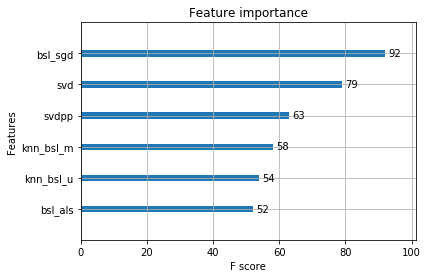

In [45]:
import xgboost as xgb
import matplotlib.pyplot as plt
xgb.plot_importance(algo)
plt.show()